# k-Nearest Neighbour experiment

In [1]:
%matplotlib inline

## Load data

In [9]:
from imbatcher.Decoder import Decoder


paths = ["/home/yordwynn/Image/screenshots/true/",
         "/home/yordwynn/Image/screenshots/false/"]
labels = [1, 0]
data = Decoder.decode_png_images(paths, labels, 0.4)
x_data = data["data"]
y_data = data["labels"]

## Print data

Print 5 positive and 5 negative random images

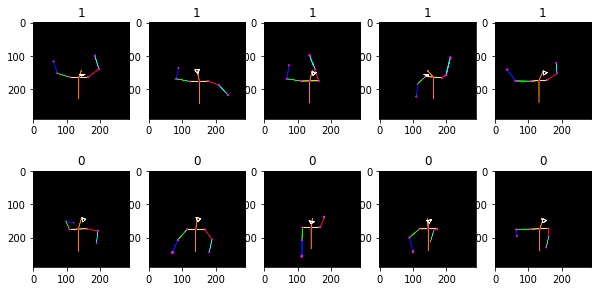

In [10]:
import numpy as np
import matplotlib.pyplot as plt

samples_per_class = 5
num_classes = len(labels)

y_data = np.array(y_data).reshape(-1)
x_data = np.array(x_data)

for y, item in enumerate(labels):
    idxs = np.flatnonzero(y_data == item)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        image = x_data[idxs[i]]
        image = image.reshape(288, 288, 3)
        label = y_data[idxs[i]]
        plt.subplot(num_classes, samples_per_class, i + 1 + y * samples_per_class)
        plt.imshow(image)
        plt.title(label)
        
plt.show()

## Search the best parameters for uniform weights

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier


metric = ["euclidean", "manhattan", "chebyshev"]
metric_count = len(metric)

n_neighbors = range(1, 6)
n_neghbors_count = len(n_neighbors)

weights = ["uniform", "distance"]
weights_count = len(weights)

classifier = KNeighborsClassifier(algorithm="kd_tree")
param_grid = {"weights": weights, "metric": metric, "n_neighbors": n_neighbors}
scoring = {"accuracy": make_scorer(accuracy_score)}

gs = GridSearchCV(classifier, param_grid=param_grid, scoring=scoring,
                  cv=5, refit='accuracy', return_train_score=True, iid=False)
gs.fit(x_data[257:357], y_data[257:357])

results = gs.cv_results_
best_params = gs.best_params_
best_score = gs.best_score_

print(best_params)
print(best_score)

{'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
0.5700000000000001


In [20]:
print(results)

{'mean_fit_time': array([0.15031457, 0.1487082 , 0.1502799 , 0.14941912, 0.14928446,
       0.15037341, 0.15047297, 0.14904785, 0.149856  , 0.15012264,
       0.15012131, 0.14916868, 0.14914193, 0.14842987, 0.14883175,
       0.14910274, 0.14756999, 0.14730372, 0.14859281, 0.14803872,
       0.14312363, 0.1429482 , 0.14341235, 0.14401932, 0.1441505 ,
       0.14455132, 0.14369307, 0.14469194, 0.14575944, 0.14663668]), 'std_fit_time': array([0.00247932, 0.00063305, 0.00132605, 0.00144978, 0.00146195,
       0.00090297, 0.00095709, 0.00087313, 0.00070562, 0.00073964,
       0.00190923, 0.00112974, 0.00098962, 0.00143576, 0.00166383,
       0.00088043, 0.00041783, 0.00124471, 0.0012492 , 0.00030449,
       0.00137781, 0.00140487, 0.00083369, 0.0010653 , 0.00110066,
       0.00115794, 0.00068677, 0.00127646, 0.00279138, 0.00077107]), 'mean_score_time': array([0.51579328, 0.51131463, 0.51498132, 0.51053586, 0.51042347,
       0.51047444, 0.51253028, 0.51038404, 0.51226749, 0.51106629,
     

## Process results

In [26]:
best_weight_id = weights.index(best_params["weights"])
best_metric_id = metric.index(best_params["metric"])
best_n_neighbors = n_neighbors.index(best_params["n_neighbors"])

### Extract and reshape results

In [53]:
keys = []
prep_result = {}

for score in scoring:
    keys.append("mean_test_%s" % (score))
    keys.append("mean_train_%s" % (score))
    keys.append("std_test_%s" % (score))
    keys.append("std_train_%s" % (score))
    keys.append("rank_test_%s" % (scorer))
    
for key in keys:
    res = results[key]
    res = res.reshape((metric_count, n_neghbors_count, weights_count))
    res = res.transpose(2, 0, 1)
    prep_result[key] = res
    
print(prep_result["rank_test_accuracy"])

[[[18  1  4  1  9]
  [ 9  6  9  3  9]
  [21 21 21 21 21]]

 [[18 18  4  6  9]
  [ 9  9  9  6  9]
  [21 21 21 21 21]]]


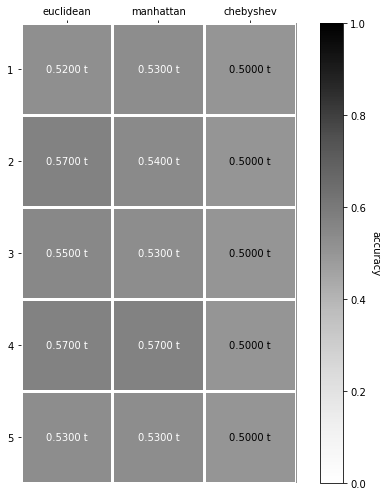

In [51]:
from heat_map import heatmap, annotate_heatmap

heatmap_metric = "accuracy"
mean_test_score = prep_result["mean_test_%s" % (heatmap_metric)][best_weight_id]
mean_test_score = mean_test_score.transpose(1, 0)

plt.rcParams["figure.figsize"]=[7, 7]
fig, ax = plt.subplots()

im, cbar = heatmap(mean_test_score, n_neighbors, metric, ax=ax, cmap="Greys", vmin=0, vmax=1, cbarlabel=heatmap_metric)
texts = annotate_heatmap(im, valfmt="{x:.4f} t", textcolors=["black", "white"], threshold=0.5)

fig.tight_layout()
plt.show()

## Show plot for the best weight and metric

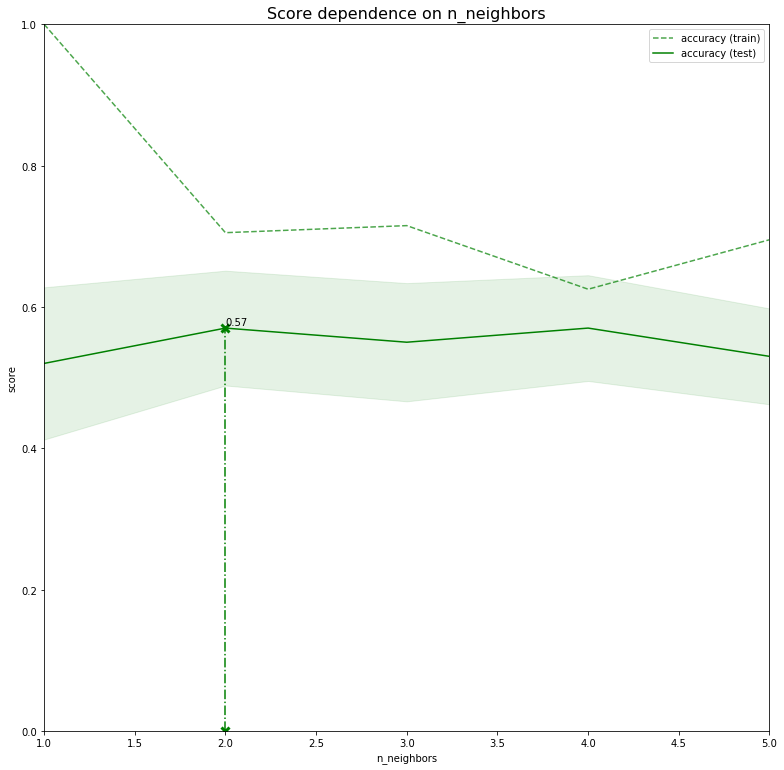

In [55]:
plt.figure(figsize=(13, 13))
plt.title("Score dependence on n_neighbors",
          fontsize=16)

plt.xlabel("n_neighbors")
plt.ylabel("score")

ax = plt.gca()
ax.set_xlim(1, n_neghbors_count)
ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(n_neighbors, dtype=int)
    

for scorer, color in zip(sorted(scoring), ['g', 'k', 'b']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = prep_result['mean_%s_%s' % (sample, scorer)][best_weight_id][best_metric_id]
        sample_score_std = prep_result['std_%s_%s' % (sample, scorer)][best_weight_id][best_metric_id]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    rank_test = prep_result['rank_test_%s' % scorer][best_weight_id][best_metric_id]
    best_rank = rank_test.min()
    best_index = np.nonzero(rank_test == best_rank)[0][0]
    best_score = prep_result['mean_test_%s' % scorer][best_weight_id][best_metric_id][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
        linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
            (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [14]:
classifier = KNeighborsClassifier(algorithm="kd_tree", weights="uniform", metric="chebyshev")
param_grid = {"n_neighbors": n_neighbors}
scoring = {"accuracy": make_scorer(accuracy_score),
           "f1": make_scorer(f1_score)}

gs = GridSearchCV(classifier, param_grid=param_grid, scoring=scoring, cv=5,
                  refit='f1', return_train_score=True, iid=False)
gs.fit(x_data[257:357], y_data[257:357])
results = gs.cv_results_
print(gs.best_params_)
print(gs.best_score_)

/home/yordwynn/anaconda3/envs/phd-reps/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yordwynn/anaconda3/envs/phd-reps/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yordwynn/anaconda3/envs/phd-reps/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yordwynn/anaconda3/envs/phd-reps/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_f

{'n_neighbors': 5}
0.6666666666666666


In [12]:
classifier = KNeighborsClassifier(algorithm="kd_tree", weights="uniform")
param_grid = {"metric": metric, "n_neighbors": n_neighbors}
scoring = {"accuracy": make_scorer(accuracy_score),
           "f1": make_scorer(f1_score)}

gs = GridSearchCV(classifier, param_grid=param_grid, scoring=scoring, cv=5,
                  refit='f1', return_train_score=True, iid=False)
gs.fit(x_data[257:357], y_data[257:357])
results = gs.cv_results_
print(gs.best_params_)
print(gs.best_score_)

/home/yordwynn/anaconda3/envs/phd-reps/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yordwynn/anaconda3/envs/phd-reps/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yordwynn/anaconda3/envs/phd-reps/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yordwynn/anaconda3/envs/phd-reps/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_f

{'metric': 'chebyshev', 'n_neighbors': 5}
0.6666666666666666
